# Callbacks : turn your maps into interactive widgets

-  **Callback functions** can easily be attached to the plot to turn it
   into an interactive plot-widget!

   - | there’s a nice list of (customizable) pre-defined callbacks accessible via:
     | ``m.cb.click``, ``m.cb.pick``, ``m.cb.keypress`` and ``m.cb.dynamic``

      -  use ``annotate`` (and ``clear_annotations``) to create text-annotations
      -  use ``mark`` (and ``clear_markers``) to add markers
      -  use ``peek_layer`` (and ``switch_layer``) to compare multiple layers of data
      -  ... and many more: ``plot``, ``print_to_console``, ``get_values``, ``load`` ...

   -  | ... but you can also define a custom one and connect it via
      | ``m.cb.click.attach(<my custom function>)`` (works also with ``pick`` and ``keypress``)!

![image](../../../_static/example_images/example_callbacks.gif)

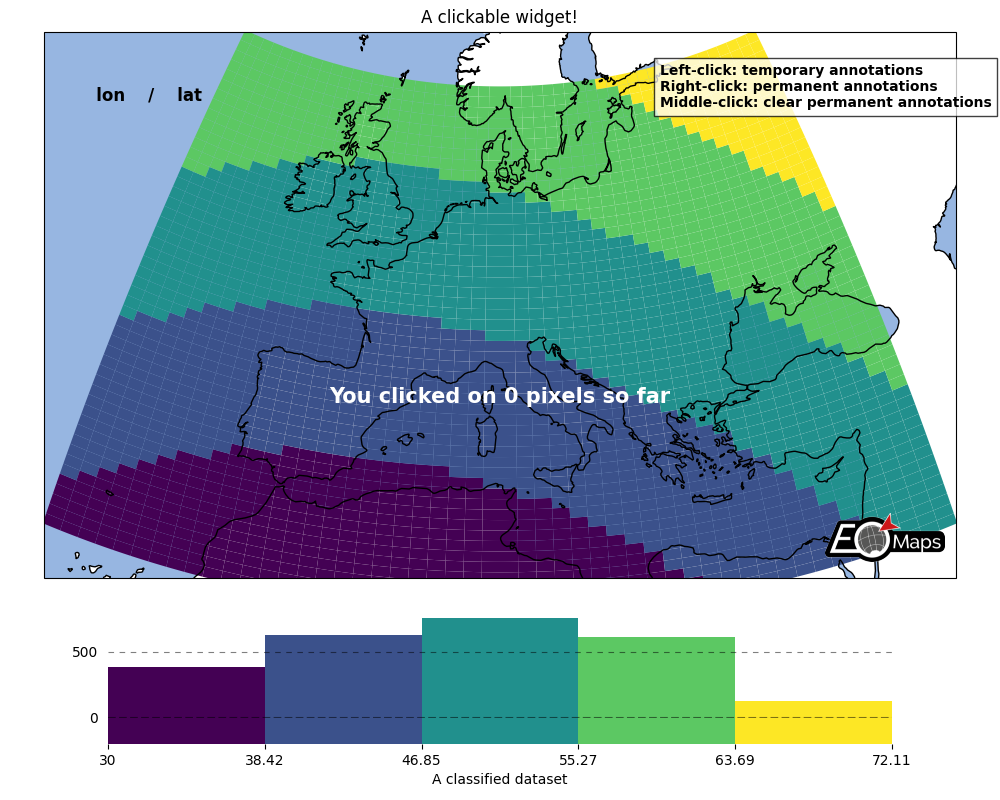

In [1]:
# EOmaps example: Turn your maps into a powerful widgets

from eomaps import Maps
import pandas as pd
import numpy as np

# create some data
lon, lat = np.meshgrid(np.linspace(-20, 40, 50), np.linspace(30, 60, 50))

data = pd.DataFrame(
    dict(lon=lon.flat, lat=lat.flat, data=np.sqrt(lon**2 + lat**2).flat)
)

# --------- initialize a Maps object and plot a basic map
m = Maps(crs=3035, figsize=(10, 8))
m.set_data(data=data, x="lon", y="lat", crs=4326)
m.ax.set_title("A clickable widget!")
m.set_shape.rectangles()

m.set_classify_specs(scheme="EqualInterval", k=5)
m.add_feature.preset.coastline()
m.add_feature.preset.ocean()
m.plot_map()

# add some static text
m.text(
    0.66,
    0.92,
    (
        "Left-click: temporary annotations\n"
        "Right-click: permanent annotations\n"
        "Middle-click: clear permanent annotations"
    ),
    fontsize=10,
    horizontalalignment="left",
    verticalalignment="top",
    color="k",
    fontweight="bold",
    bbox=dict(facecolor="w", alpha=0.75),
)


# --------- attach pre-defined CALLBACK functions ---------

### add a temporary annotation and a marker if you left-click on a pixel
m.cb.pick.attach.mark(
    button=1,
    permanent=False,
    fc=[0, 0, 0, 0.5],
    ec="w",
    ls="--",
    buffer=2.5,
    shape="ellipses",
    zorder=1,
)
m.cb.pick.attach.annotate(
    button=1,
    permanent=False,
    bbox=dict(boxstyle="round", fc="w", alpha=0.75),
    zorder=999,
)
### save all picked values to a dict accessible via m.cb.get.picked_vals
m.cb.pick.attach.get_values(button=1)

### add a permanent marker if you right-click on a pixel
m.cb.pick.attach.mark(
    button=3,
    permanent=True,
    facecolor=[1, 0, 0, 0.5],
    edgecolor="k",
    buffer=1,
    shape="rectangles",
    zorder=1,
)


### add a customized permanent annotation if you right-click on a pixel
def text(m, ID, val, pos, ind):
    return f"ID={ID}"


m.cb.pick.attach.annotate(
    button=3,
    permanent=True,
    bbox=dict(boxstyle="round", fc="r"),
    text=text,
    xytext=(10, 10),
    zorder=2,  # use zorder=2 to put the annotations on top of the markers
)

### remove all permanent markers and annotations if you middle-click anywhere on the map
m.cb.pick.attach.clear_annotations(button=2)
m.cb.pick.attach.clear_markers(button=2)

# --------- define a custom callback to update some text to the map
# (use a high zorder to draw the texts above all other things)
txt = m.text(
    0.5,
    0.35,
    "You clicked on 0 pixels so far",
    fontsize=15,
    horizontalalignment="center",
    verticalalignment="top",
    color="w",
    fontweight="bold",
    animated=True,
    zorder=99,
    transform=m.ax.transAxes,
)
txt2 = m.text(
    0.18,
    0.9,
    "   lon    /    lat " + "\n",
    fontsize=12,
    horizontalalignment="right",
    verticalalignment="top",
    fontweight="bold",
    animated=True,
    zorder=99,
    transform=m.ax.transAxes,
)


def cb1(m, pos, ID, val, **kwargs):
    # update the text that indicates how many pixels we've clicked
    nvals = len(m.cb.pick.get.picked_vals["ID"])
    txt.set_text(
        f"You clicked on {nvals} pixel"
        + ("s" if nvals > 1 else "")
        + "!\n... and the "
        + ("average " if nvals > 1 else "")
        + f"value is {np.mean(m.cb.pick.get.picked_vals['val']):.3f}"
    )

    # update the list of lon/lat coordinates on the top left of the figure
    d = m.data.loc[ID]
    lonlat_list = txt2.get_text().splitlines()
    if len(lonlat_list) > 10:
        lonlat_txt = lonlat_list[0] + "\n" + "\n".join(lonlat_list[-10:]) + "\n"
    else:
        lonlat_txt = txt2.get_text()
    txt2.set_text(lonlat_txt + f"{d['lon']:.2f}  /  {d['lat']:.2f}" + "\n")


m.cb.pick.attach(cb1, button=1, m=m)


def cb2(m, pos, val, **kwargs):
    # plot a marker at the pixel-position
    (l,) = m.ax.plot(*pos, marker="*", animated=True)
    # add the custom marker to the blit-manager!
    m.BM.add_artist(l)

    # print the value at the pixel-position
    # use a low zorder so the text will be drawn below the temporary annotations
    m.text(
        pos[0],
        pos[1] - 150000,
        f"{val:.2f}",
        horizontalalignment="center",
        verticalalignment="bottom",
        color=l.get_color(),
        zorder=1,
        transform=m.ax.transData,
    )


m.cb.pick.attach(cb2, button=3, m=m)

# add a "target-indicator" on mouse-movement
m.cb.move.attach.mark(fc="r", ec="none", radius=10000, shape="geod_circles")
m.cb.move.attach.mark(fc="none", ec="r", radius=50000, shape="geod_circles")

# add a colorbar
m.add_colorbar(hist_bins="bins", label="A classified dataset")
m.add_logo()

m.apply_layout(
    {
        "figsize": [10.0, 8.0],
        "0_map": [0.04375, 0.27717, 0.9125, 0.69566],
        "1_cb": [0.01, 0.0, 0.98, 0.23377],
        "1_cb_histogram_size": 0.8,
        "2_logo": [0.825, 0.29688, 0.12, 0.06188],
    }
)
m.show()